# Load and Visualize FashionMNIST
---
In this notebook, I load and look at images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

The first step in any classification problem is to look at the dataset. This give me some details about the format of images and labels, as well as some insight into how I might approach defining a network to recognize patterns in such an image set.

For this work, I have used PyTorch as it has some built-in datasets one can use, and FashionMNIST is one of them; it has already been dowloaded into the `data/` directory in this notebook, so all we have to do is load these images using the FashionMNIST dataset class *and* load the data in batches with a `DataLoader`.

My workflow is structured as follow:

    (1) Download dataset (Using Dataloader)
    
    (2) Visualize dataset
    
    (3) Two CNN layers and two fully connected layers are created
        
    (4) Train and Evaluate LeNet
    
    (5) Visualization Loss Plot

    Where to go from here?
    
    Conclusion
    

### Download datasets

#### Dataset class and Tensors

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. The FashionMNIST class is an extension of this Dataset class and it allows us to 1. load batches of image/label data, and 2. uniformly apply transformations to our data, such as turning all our images into Tensor's for training a neural network. *Tensors are similar to numpy arrays, but can also be used on a GPU to accelerate computing.*

Let's see how to construct a training dataset.

In [1]:
# Import the required libraries
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# I transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                   download=True, transform=data_transform)

# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


#### Data iteration and batching

Once I download the training data, I use now, as explained above,  'torch.utils.data.DataLoader' to load the dataset. DataLoader also gives us the ability to iterate over the dataset.

In [2]:
batch_size = 20

#loading the training data from trainset
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

#loading the test data from testset
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle= True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

C:\Users\adjanni\anaconda3\envs\Tensorflow36\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


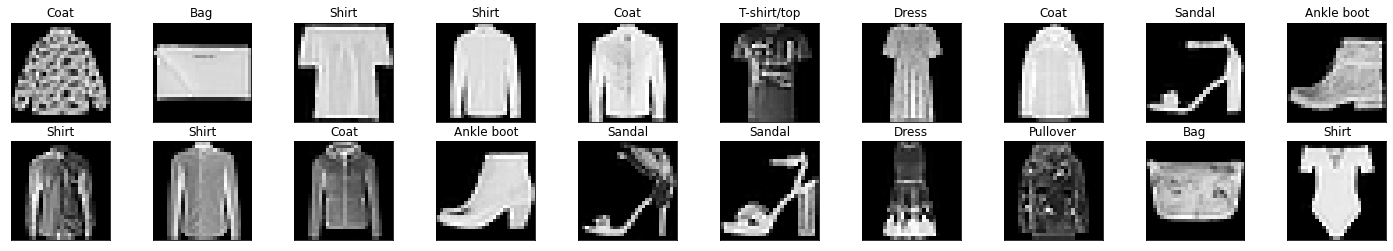

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### View an image in more detail

Each image in this dataset is a `28x28` pixel, normalized, grayscale image.

#### A note on normalization

Normalization ensures that, as we go through a feedforward and then backpropagation step in training our CNN, that each image feature will fall within a similar range of values and not overly activate any particular layer in our network. During the feedfoward step, a network takes in an input image and multiplies each input pixel by some convolutional filter weights (and adds biases!), then it applies some activation and pooling functions. Without normalization, it's much more likely that the calculated gradients in the backpropagaton step will be quite large and cause our loss to increase instead of converge.


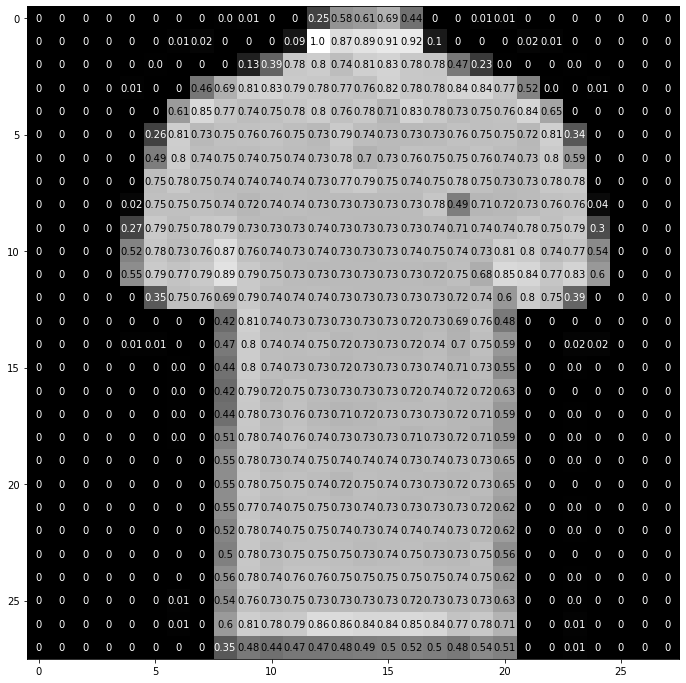

In [23]:
# select an image by index
idx = 12
img = np.squeeze(images[idx])

# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### Define the network architecture

The various layers that make up any neural network are documented, [here](https://pytorch.org/docs/stable/nn.html). For a convolutional neural network, I will use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # Output size = (W - F + 2P)/S + 1 = (28 - 3 + 2*0)/1 + 1 = 26, where W = image width, F = filter Size, S = stride, P=paddling
        # The output image for one image, will have the dimension: (10, 26, 26)
        # After one pool, the dimension of the image becomes: (10, 13, 13)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride = 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Second conv layer
        # Output size = (13 - 3)/1 + 1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # After another pool out, the dimensions are = (20, 5, 5); 5.5 is rounded down!
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 3)
        
        # 20 outputs * the 5x5 filtered/pooled map size 
        self.fc1 = nn.Linear(20*5*5, 50) 
 
        # dropout with p = 0.4. This means that 40% of the neurons are turned off per EPOCH
        # this allows all nodes to work equally toward the same goal!
        self.fc1_drop = nn.Dropout(p=0.5)
        
        # Finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)
        
        
    # Define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Prep for linear layer
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # Two linear layers with a dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## Feature Visualization


I am using this technique to visualize and to understand the inner workings of CNN.

First convolutional layer


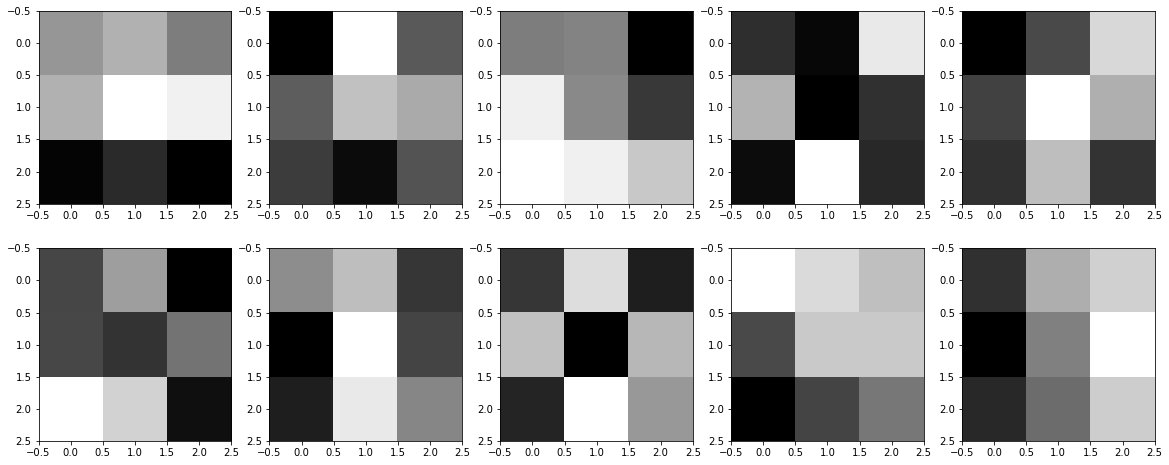

In [18]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()


# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

**Observation** The filter on the top left side has dark and dark-gray pixels on the bottom and top side, respectively. It also has light pixels in the middle column. This means that it may detecting horizontal edges!

### Activation Maps

Next, I will show how OpenCV's `filter2D` function apply these filters to a sample test image and produce a series of **activation maps** as a result. I will do this for the first and second convolutional layers of this work! These activation maps will really give you, the reader of this notebook, a sense for what features each filter learns to extract.

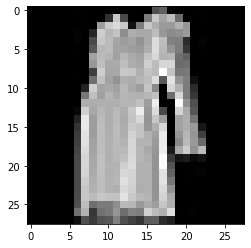

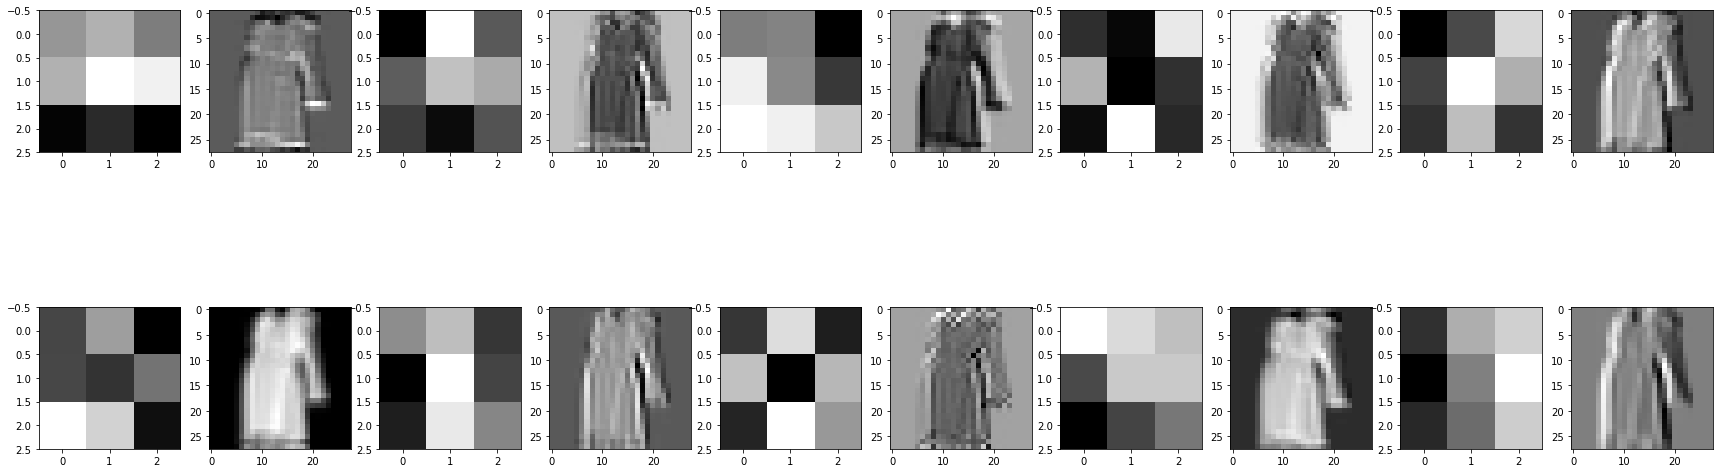

In [30]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 12
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

**conv1** the very first filter (top - left) seems to detect the shirt horizontal edges!

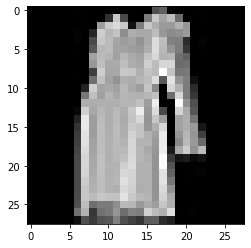

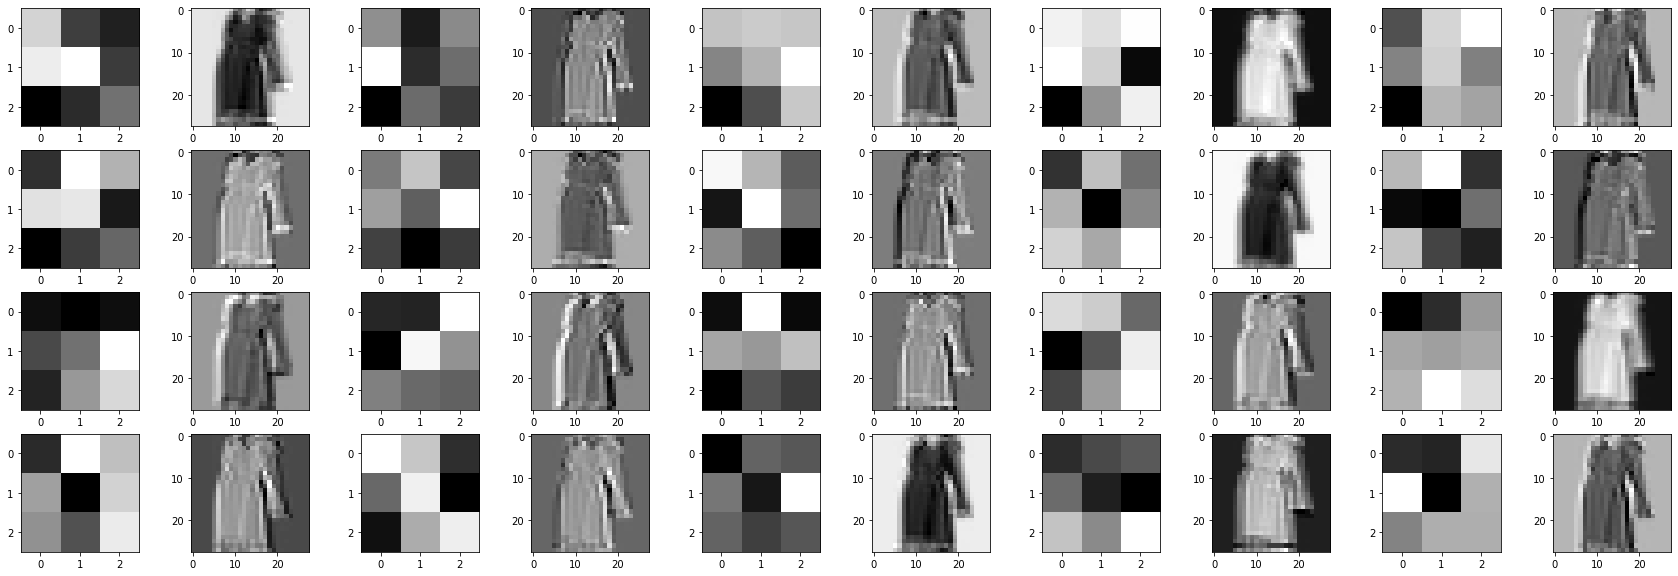

In [31]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

**conv2** the first filter looks like it may be detecting the background color (since that is the brightest area in the filtered image) and the vertical edges of the pullover.

 ### Specify the loss function and optimizer¶

In [6]:
import torch.optim as optim

## specify loss function 
# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

## specify optimizer 
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

### A note on accuracy

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

In [7]:
from torch.autograd import Variable

# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct / total

# print it out!
print(" Tensor length \n", correct)
print("Total \n", total)
print('Accuracy before training: ', accuracy)



 Tensor length 
 1032
Total 
 10000
Accuracy before training:  10.32


### Train the Network

Below, I've defined a `train` function that takes in a number of epochs to train for. 
* The number of epochs is how many times a network will cycle through the entire training dataset. 
* Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 1000 batches.

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss


In [8]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [9]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.7947530727386474
Epoch: 1, Batch: 2000, Avg. Loss: 1.0816629837453364
Epoch: 1, Batch: 3000, Avg. Loss: 0.9497596161961556
Epoch: 2, Batch: 1000, Avg. Loss: 0.8566142058372498
Epoch: 2, Batch: 2000, Avg. Loss: 0.79534719902277
Epoch: 2, Batch: 3000, Avg. Loss: 0.7514986628592014
Epoch: 3, Batch: 1000, Avg. Loss: 0.7052634215354919
Epoch: 3, Batch: 2000, Avg. Loss: 0.6886976650357246
Epoch: 3, Batch: 3000, Avg. Loss: 0.6746775572821498
Epoch: 4, Batch: 1000, Avg. Loss: 0.6437206690907479
Epoch: 4, Batch: 2000, Avg. Loss: 0.645679140791297
Epoch: 4, Batch: 3000, Avg. Loss: 0.6233203848153352
Epoch: 5, Batch: 1000, Avg. Loss: 0.6174332880228758
Epoch: 5, Batch: 2000, Avg. Loss: 0.6080714214518667
Epoch: 5, Batch: 3000, Avg. Loss: 0.6016563584208489
Epoch: 6, Batch: 1000, Avg. Loss: 0.5987357171103358
Epoch: 6, Batch: 2000, Avg. Loss: 0.5784463808909058
Epoch: 6, Batch: 3000, Avg. Loss: 0.5738310825675726
Epoch: 7, Batch: 1000, Avg. Loss: 0.5600116620361


## Visualizing the loss

A good indication of how much your network is learning as it trains is the loss over time. In this example, we printed and recorded the average loss for each 1000 batches and for each epoch. Let's plot it and see how the loss decreases (or doesn't) over time.

In this case, you can see that it takes a little bit for a big initial loss decrease, and the loss is flattening out over time.

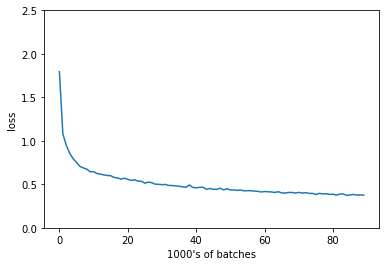

In [10]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the Trained Network

Once we are satisfied with how the loss of our model, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.

In [11]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.342753

Test Accuracy of T-shirt/top: 69% (695/1000)
Test Accuracy of Trouser: 96% (965/1000)
Test Accuracy of Pullover: 75% (757/1000)
Test Accuracy of Dress: 90% (909/1000)
Test Accuracy of  Coat: 74% (747/1000)
Test Accuracy of Sandal: 96% (964/1000)
Test Accuracy of Shirt: 76% (768/1000)
Test Accuracy of Sneaker: 95% (951/1000)
Test Accuracy of   Bag: 96% (967/1000)
Test Accuracy of Ankle boot: 95% (959/1000)

Test Accuracy (Overall): 86% (8682/10000)


### Visualize sample test results

Format: predicted class (true class)

C:\Users\adjanni\anaconda3\envs\Tensorflow36\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


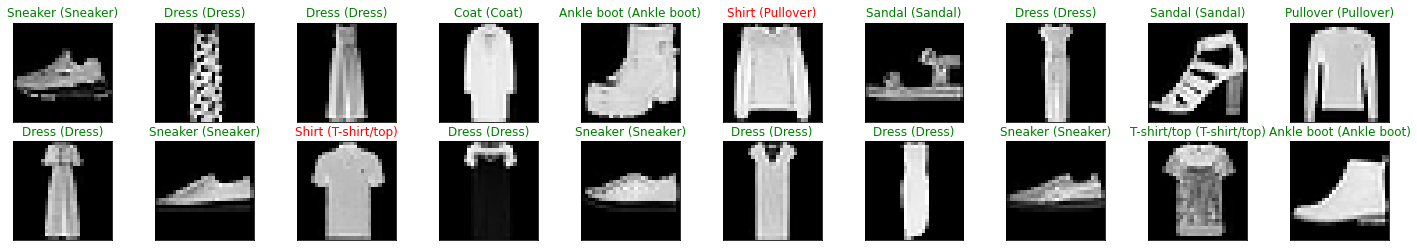

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Question: What are some weaknesses of my model? (And how might I improve these in future iterations.)

**Answer**: Since t-shirts, shirts, and coats have a similar overall shape, my model has trouble distinguishing between those items. In fact, its lowest test class accuracy is: `Test Accuracy of Shirt`, which this model only gets right about 60% of the time . 

I suspect that this accuracy could be improved by the following:

    1. Doing some data augmentation with respect to these classes 
    
    2. Adding another convolutional layer to extract even higher level features and to prevent overfitting.
    
    3. Changing the 'batch_size´ of the data_loader to see how larger batch sizes can affect your training
    
    4. Increasing the size of the convolutional kernels for larger images??

In [14]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'fashion_net_ex.pt'

# after training, save my model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)